<a href="https://colab.research.google.com/github/KenzaxTazi/Agri-Risk/blob/master/RFECV_monthly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os, sys
path = '/content/drive/My Drive/GTC'
os.chdir(path)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
%matplotlib inline
from tqdm import tqdm

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

In [31]:
ten_day_df = pd.read_csv('head_of_soils_recommendations.csv')
ten_day_df

,Unnamed: 0,alloc_key,lon,lat,iso3,maize_a_2010,maize_a_2005,BEDD-01-05-2010,BEDD-02-05-2010,BEDD-03-05-2010,BEDD-04-05-2010,BEDD-05-05-2010,BEDD-06-05-2010,BEDD-07-05-2010,BEDD-08-05-2010,BEDD-09-05-2010,BEDD-10-05-2010,BEDD-11-05-2010,BEDD-12-05-2010,BEDD-01-15-2010,BEDD-02-15-2010,BEDD-03-15-2010,BEDD-04-15-2010,BEDD-05-15-2010,BEDD-06-15-2010,BEDD-07-15-2010,BEDD-08-15-2010,BEDD-09-15-2010,BEDD-10-15-2010,BEDD-11-15-2010,BEDD-12-15-2010,BEDD-01-25-2010,BEDD-02-25-2010,BEDD-03-25-2010,BEDD-04-25-2010,BEDD-05-25-2010,BEDD-06-25-2010,BEDD-07-25-2010,BEDD-08-25-2010,BEDD-09-25-2010,...,DTR-09-25-2010,DTR-10-25-2010,DTR-11-25-2010,DTR-12-25-2010,DTR-01-05-2005,DTR-02-05-2005,DTR-03-05-2005,DTR-04-05-2005,DTR-05-05-2005,DTR-06-05-2005,DTR-07-05-2005,DTR-08-05-2005,DTR-09-05-2005,DTR-10-05-2005,DTR-11-05-2005,DTR-12-05-2005,DTR-01-15-2005,DTR-02-15-2005,DTR-03-15-2005,DTR-04-15-2005,DTR-05-15-2005,DTR-06-15-2005,DTR-07-15-2005,DTR-08-15-2005,DTR-09-15-2005,DTR-10-15-2005,DTR-11-15-2005,DTR-12-15-2005,DTR-01-25-2005,DTR-02-25-2005,DTR-03-25-2005,DTR-04-25-2005,DTR-05-25-2005,DTR-06-25-2005,DTR-07-25-2005,DTR-08-25-2005,DTR-09-25-2005,DTR-10-25-2005,DTR-11-25-2005,DTR-12-25-2005
0,0,4383640,123.291667,53.541667,CHN,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,41.363127,58.864516,37.987717,35.519341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.397859,35.972803,70.771844,47.295640,13.864582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.759598,117.686572,78.207775,51.866659,0.000000,...,11.727703,13.787956,9.926498,11.371226,12.503196,12.908701,16.032727,13.402978,11.735192,16.610372,9.410874,15.312115,13.542417,16.038854,9.848100,12.936875,15.138467,19.237968,18.427092,11.584098,15.175377,14.674588,14.688044,15.483794,11.441020,11.420742,15.016444,10.487718,13.816922,18.504860,18.507736,15.031678,17.593290,15.704611,18.523022,14.092479,15.016566,13.988310,18.100036,12.329345
1,2,4393629,122.375000,53.458333,CHN,3119.3,2028.5,0.000000,0.000000,0.000000,0.000000,0.000000,46.733022,67.613537,43.898331,36.698276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.459904,39.495712,78.767241,52.374707,14.427820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.772268,125.595174,83.146588,55.973652,0.000000,...,11.912833,13.628348,11.160431,11.007959,12.945838,12.618908,17.508302,13.575372,12.651447,16.761110,9.316199,15.640966,14.423927,16.998112,9.292246,12.221441,14.103506,20.599868,19.241434,12.576798,15.924542,14.954824,14.986558,15.608261,12.051438,11.944841,14.345663,10.443484,13.584308,18.917152,18.651182,15.191576,16.881676,16.390320,18.770228,14.457341,15.568386,14.757354,18.749596,12.080565
2,7,4403648,123.958333,53.375000,CHN,3230.1,2337.9,0.000000,0.000000,0.000000,0.000000,0.000000,42.146906,58.197767,38.470460,36.390766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.700476,37.185835,69.226086,48.036306,16.367400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.950559,116.095221,79.417204,53.371251,0.000000,...,11.412658,13.940518,9.111539,11.555232,12.414833,13.285697,15.601179,13.165404,10.974052,16.134251,9.555662,14.871300,12.659969,15.561574,10.324795,13.343145,14.664218,18.112774,17.477607,11.057737,14.727950,14.167884,14.187781,15.036729,11.477290,11.496888,15.057879,11.031311,14.502568,18.348780,18.019471,14.658110,18.091173,15.529109,18.057473,14.120732,14.818996,13.382273,17.323588,12.099928
3,8,4403649,124.041667,53.375000,CHN,3119.3,2010.2,0.000000,0.000000,0.000000,0.000000,0.000000,42.653685,58.725946,39.027351,36.776440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.783617,37.781733,69.630878,48.656871,16.629891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.459567,116.369432,80.279322,54.095035,0.000000,...,11.393748,13.889010,8.999466,11.520067,12.391664,13.244279,15.525052,13.112559,10.872659,16.008852,9.590657,14.801929,12.553973,15.462869,10.335471,13

In [0]:
cols = ten_day_df.columns.tolist()
#cols

In [33]:
ten_day_features_df = ten_day_df.drop(['Unnamed: 0', 'alloc_key', 'alloc_key', 'iso3'], axis=1)
ten_day_features_df

,lon,lat,maize_a_2010,maize_a_2005,BEDD-01-05-2010,BEDD-02-05-2010,BEDD-03-05-2010,BEDD-04-05-2010,BEDD-05-05-2010,BEDD-06-05-2010,BEDD-07-05-2010,BEDD-08-05-2010,BEDD-09-05-2010,BEDD-10-05-2010,BEDD-11-05-2010,BEDD-12-05-2010,BEDD-01-15-2010,BEDD-02-15-2010,BEDD-03-15-2010,BEDD-04-15-2010,BEDD-05-15-2010,BEDD-06-15-2010,BEDD-07-15-2010,BEDD-08-15-2010,BEDD-09-15-2010,BEDD-10-15-2010,BEDD-11-15-2010,BEDD-12-15-2010,BEDD-01-25-2010,BEDD-02-25-2010,BEDD-03-25-2010,BEDD-04-25-2010,BEDD-05-25-2010,BEDD-06-25-2010,BEDD-07-25-2010,BEDD-08-25-2010,BEDD-09-25-2010,BEDD-10-25-2010,BEDD-11-25-2010,BEDD-12-25-2010,...,DTR-09-25-2010,DTR-10-25-2010,DTR-11-25-2010,DTR-12-25-2010,DTR-01-05-2005,DTR-02-05-2005,DTR-03-05-2005,DTR-04-05-2005,DTR-05-05-2005,DTR-06-05-2005,DTR-07-05-2005,DTR-08-05-2005,DTR-09-05-2005,DTR-10-05-2005,DTR-11-05-2005,DTR-12-05-2005,DTR-01-15-2005,DTR-02-15-2005,DTR-03-15-2005,DTR-04-15-2005,DTR-05-15-2005,DTR-06-15-2005,DTR-07-15-2005,DTR-08-15-2005,DTR-09-15-2005,DTR-10-15-2005,DTR-11-15-2005,DTR-12-15-2005,DTR-01-25-2005,DTR-02-25-2005,DTR-03-25-2005,DTR-04-25-2005,DTR-05-25-2005,DTR-06-25-2005,DTR-07-25-2005,DTR-08-25-2005,DTR-09-25-2005,DTR-10-25-2005,DTR-11-25-2005,DTR-12-25-2005
0,123.291667,53.541667,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,41.363127,58.864516,37.987717,35.519341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.397859,35.972803,70.771844,47.295640,13.864582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.759598,117.686572,78.207775,51.866659,0.000000,0.000000,0.000000,0.000000,...,11.727703,13.787956,9.926498,11.371226,12.503196,12.908701,16.032727,13.402978,11.735192,16.610372,9.410874,15.312115,13.542417,16.038854,9.848100,12.936875,15.138467,19.237968,18.427092,11.584098,15.175377,14.674588,14.688044,15.483794,11.441020,11.420742,15.016444,10.487718,13.816922,18.504860,18.507736,15.031678,17.593290,15.704611,18.523022,14.092479,15.016566,13.988310,18.100036,12.329345
1,122.375000,53.458333,3119.3,2028.5,0.000000,0.000000,0.000000,0.000000,0.000000,46.733022,67.613537,43.898331,36.698276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.459904,39.495712,78.767241,52.374707,14.427820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.772268,125.595174,83.146588,55.973652,0.000000,0.000000,0.000000,0.000000,...,11.912833,13.628348,11.160431,11.007959,12.945838,12.618908,17.508302,13.575372,12.651447,16.761110,9.316199,15.640966,14.423927,16.998112,9.292246,12.221441,14.103506,20.599868,19.241434,12.576798,15.924542,14.954824,14.986558,15.608261,12.051438,11.944841,14.345663,10.443484,13.584308,18.917152,18.651182,15.191576,16.881676,16.390320,18.770228,14.457341,15.568386,14.757354,18.749596,12.080565
2,123.958333,53.375000,3230.1,2337.9,0.000000,0.000000,0.000000,0.000000,0.000000,42.146906,58.197767,38.470460,36.390766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.700476,37.185835,69.226086,48.036306,16.367400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.950559,116.095221,79.417204,53.371251,0.000000,0.000000,0.000000,0.000000,...,11.412658,13.940518,9.111539,11.555232,12.414833,13.285697,15.601179,13.165404,10.974052,16.134251,9.555662,14.871300,12.659969,15.561574,10.324795,13.343145,14.664218,18.112774,17.477607,11.057737,14.727950,14.167884,14.187781,15.036729,11.477290,11.496888,15.057879,11.031311,14.502568,18.348780,18.019471,14.658110,18.091173,15.529109,18.057473,14.120732,14.818996,13.382273,17.323588,12.099928
3,124.041667,53.375000,3119.3,2010.2,0.000000,0.000000,0.000000,0.000000,0.000000,42.653685,58.725946,39.027351,36.776440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.783617,37.781733,69.630878,48.656871,16.629891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.459567,116.369432,80.279322,54.095035,0.000000,0.000000,0.000000,0.000000,...,11.393748,13.889010,8.999466,11.520067,12.391664,13.244279,15.525052,13.1125

In [34]:
ten_days = [
    'BEDD',
    'FD',
    'R20mm',
    'RR1',
    'DTR'
]
years = ['2005', '2010']
days = ['05', '15', '25']
months = [
    '01',
    '02',
    '03',
    '04',
    '05',
    '06',
    '07',
    '08',
    '09',
    '10',
    '11',
    '12'
]
all_ten_days = []
for feature in tqdm(ten_days):
    for month in months:
        for year in years:
            for day in days:
                all_ten_days.append(f'{feature}-{month}-{day}-{year}')
            ten_day_features_df[f'{feature}-{month}-{year}'] = ten_day_features_df[f'{feature}-{month}-05-{year}'] + ten_day_features_df[f'{feature}-{month}-15-{year}'] + ten_day_features_df[f'{feature}-{month}-25-{year}']
monthly_features_df = ten_day_features_df.drop(columns=all_ten_days)
del ten_day_features_df

100%|██████████| 5/5 [00:06<00:00,  1.90s/it]


In [35]:
monthly_features_df

,lon,lat,maize_a_2010,maize_a_2005,BEDD-01-2005,BEDD-01-2010,BEDD-02-2005,BEDD-02-2010,BEDD-03-2005,BEDD-03-2010,BEDD-04-2005,BEDD-04-2010,BEDD-05-2005,BEDD-05-2010,BEDD-06-2005,BEDD-06-2010,BEDD-07-2005,BEDD-07-2010,BEDD-08-2005,BEDD-08-2010,BEDD-09-2005,BEDD-09-2010,BEDD-10-2005,BEDD-10-2010,BEDD-11-2005,BEDD-11-2010,BEDD-12-2005,BEDD-12-2010,FD-01-2005,FD-01-2010,FD-02-2005,FD-02-2010,FD-03-2005,FD-03-2010,FD-04-2005,FD-04-2010,FD-05-2005,FD-05-2010,FD-06-2005,FD-06-2010,...,RR1-05-2005,RR1-05-2010,RR1-06-2005,RR1-06-2010,RR1-07-2005,RR1-07-2010,RR1-08-2005,RR1-08-2010,RR1-09-2005,RR1-09-2010,RR1-10-2005,RR1-10-2010,RR1-11-2005,RR1-11-2010,RR1-12-2005,RR1-12-2010,DTR-01-2005,DTR-01-2010,DTR-02-2005,DTR-02-2010,DTR-03-2005,DTR-03-2010,DTR-04-2005,DTR-04-2010,DTR-05-2005,DTR-05-2010,DTR-06-2005,DTR-06-2010,DTR-07-2005,DTR-07-2010,DTR-08-2005,DTR-08-2010,DTR-09-2005,DTR-09-2010,DTR-10-2005,DTR-10-2010,DTR-11-2005,DTR-11-2010,DTR-12-2005,DTR-12-2010
0,123.291667,53.541667,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.069718,51.157457,131.072950,195.022503,233.252640,207.844135,155.706710,137.150016,15.442465,49.383923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0,31.0,28.0,28.0,31.0,31.0,30.0,30.0,17.611111,12.430556,1.465278,0.847222,...,10.986111,8.583333,11.500000,11.368056,9.819444,19.583333,12.430556,10.569444,10.583333,4.000000,1.881944,10.534722,5.048611,4.583333,2.034722,4.416667,41.458586,40.545901,50.651529,50.259202,52.967555,56.858984,40.018753,44.579175,44.503859,45.102582,46.989570,49.639587,42.621941,36.801490,44.888387,39.978604,40.000002,43.589581,41.447906,38.357178,42.964580,38.464582,35.753938,35.565589
1,122.375000,53.458333,3119.3,2028.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.476384,49.232172,150.367439,211.823908,249.743228,229.527367,166.463721,152.246690,14.707390,51.126095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0,31.0,28.0,28.0,31.0,31.0,30.0,30.0,17.833333,12.395833,1.145833,0.729167,...,7.895833,8.541667,11.645833,10.750000,11.520833,20.562500,12.062500,10.000000,10.687500,5.916667,2.166667,10.437500,4.812500,3.000000,2.000000,6.354167,40.633651,39.821186,52.135928,51.850670,55.400919,59.701719,41.343747,44.875000,45.457665,46.105286,48.106255,50.981245,43.072986,37.902246,45.706568,39.762742,42.043750,45.737502,43.700306,40.713209,42.387505,38.287496,34.745489,35.214409
2,123.958333,53.375000,3230.1,2337.9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.127754,54.651035,131.682904,195.427961,232.696246,206.841057,159.315999,139.878016,19.254828,52.758167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0,31.0,28.0,28.0,31.0,31.0,30.0,30.0,14.083333,11.833333,1.583333,0.583333,...,12.833333,8.562500,13.166667,11.083333,7.875000,19.145833,11.833333,10.958333,10.250000,3.895833,1.708333,9.895833,5.250000,4.562500,2.750000,4.750000,41.581619,40.944014,49.747251,49.048437,51.098257,54.504991,38.881252,43.612502,43.793174,44.519078,45.831243,48.681249,41.800917,35.978750,44.028761,40.016271,38.956256,42.268750,40.440735,37.020118,42.706261,38.081249,36.474383,35.592393
3,124.041667,53.375000,3119.3,2010.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.657463,55.243184,133.733531,196.804850,234.633687,208.636147,160.895045,141.779256,20.115594,53.406331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0,31.0,28.0,28.0,31.0,31.0,30.0,30.0,13.916667,11.666667,1.416667,0.416667,...,12.666667,8.687500,13.333333,10.916667,7.625000,19.104167,11.666667,11.041667,10.250000,3.854167,1.291667,9.854167,5.250000,4.687500,2.750000,4.750000,41.467615,40.790187,49.489929,48.771255,50.787164,54.141355,38.743749,43.537503,43.649199,44.381030,45.593747,48.443749,41.704554,35.773763,43.824902,39.913218,38.818755,42.106251,40.205862,36.766935,42.568762,37.893749,36.363280,35.415074
4,123.041667,53.291667,3918.1,2819.2,0.000000,0.000000,0.000000,0.0

In [0]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection
from sklearn.model_selection import KFold
import time

In [0]:
pipe = Pipeline(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500,n_jobs=-1))
    ])

In [0]:
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [0]:
feature_names = monthly_features_df.drop(['maize_a_2010','lat','lon'], axis=1).columns

In [0]:
monthly_features_df.dropna(inplace=True)
X = monthly_features_df.drop(['maize_a_2010'], axis=1).drop(['lat','lon'], axis=1)[0:1000]
y = monthly_features_df['maize_a_2010'][0:1000]

In [0]:
start = time.time()
pipe = PipelineRFE([('std_scaler', preprocessing.StandardScaler()),
     ("RF", RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1))])
_ = KFold(random_state=42, shuffle=True)
feature_selector_cv = feature_selection.RFECV(pipe, cv=10, step=1, scoring="neg_mean_squared_error")
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

training time: 11575.180420160294s
number of features: 14


In [0]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([1746.81813638, 1513.24274477, 1318.93168554, 1189.65871307,
       1227.83683433, 1183.08522898, 1192.9219885 , 1201.77439671,
       1193.32924603, 1201.3761071 , 1166.24097312, 1161.91478623,
       1146.76449922, 1146.60867491, 1151.55292193, 1151.37839613,
       1150.70610248, 1176.64458934, 1179.52305821, 1181.99796702,
       1175.94624809, 1176.88555733, 1178.68485936, 1178.29984732,
       1183.00190555, 1197.60962474, 1195.61777609, 1200.72592545,
       1202.94669646, 1201.85177341, 1199.82772585, 1204.45817085,
       1199.97579059, 1191.15364756, 1192.17680571, 1196.8959129 ,
       1188.49748897, 1190.39805297, 1182.37855346, 1186.29886883,
       1181.96989419, 1186.56845235, 1187.05442529, 1182.03471855,
       1183.65429994, 1185.47752259, 1181.41747923, 1185.78869624,
       1185.09407217, 1185.87330111, 1169.8298754 , 1168.04491094,
       1170.6509105 , 1168.96795166, 1171.81636243, 1173.78381797,
       1171.25717645, 1170.62619976, 1172.7628908 , 1166.99573

In [0]:
selected_features = feature_names[feature_selector_cv.support_].tolist()
selected_features

['maize_a_2005',
 'BEDD-08-2010',
 'BEDD-09-2010',
 'BEDD-10-2005',
 'FD-05-2005',
 'FD-10-2010',
 'RR1-03-2005',
 'RR1-04-2005',
 'RR1-05-2010',
 'RR1-06-2010',
 'RR1-08-2005',
 'RR1-09-2005',
 'RR1-12-2005',
 'DTR-09-2010']

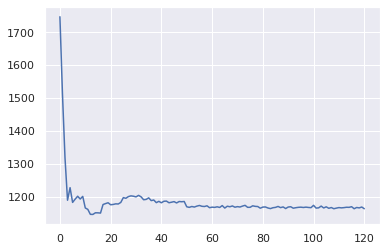

In [0]:
plt.plot(cv_grid_rmse)

In [0]:
sf = pd.DataFrame(data={"selected_features": selected_features})
sf.to_csv("./selected_features.csv", sep=',',index=False)

In [0]:
cvgrid = pandas.DataFrame(data={"cv_grid_rmse": cv_grid_rmse.tolist()})
cvgrid.to_csv("./cvgrid_rmse.csv", sep=',',index=False)